In [1]:
print('Loading modules....')

import os, sys


import uproot
import numpy as np
import matplotlib.pyplot as plt
from qetpy.utils import lowpassfilter 
from qetpy import autocuts
import cdms
#from CDMSDataCatalog import CDMSDataCatalog
import scipy.optimize as optimize
import matplotlib as mpl
import pickle as pkl
import ROOT as rt
import seaborn as sns
import operator as op
import pandas as pd
from collections import Counter

print('modules loaded...')

Loading modules....


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject
/usr/local/lib/python3.8/dist-packages/CDMSDataCatalog/CDMSDataCatalog.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in 

Welcome to JupyROOT 6.24/06
modules loaded...


In [2]:
dataset = 'v2.1.1'
detNum = 1

In [3]:
prod='CUTE_T3_GeActivation_%s_V05-00_P0.2.'%(dataset)
base = '/fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/%s/Submerged'%(prod)

if(dataset == 'prompt'):
    base = '/fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged'
    prod = 'Prompt_V04-15_P0.2.1'


file_prefix = prod

#Only 4 series
series = ['23231219_034952','23231219_110331','23231218_223530','23231217_212512']

# 11 data series
# series = [
#     '23231220_012745','23231219_184002','23231219_110331','23231219_034952','23231218_223530',
#     '23231218_190035','23231218_152721','23231218_093255','23231217_212512','23231217_171613',
#     '23231217_135018'
#          ]

# 20 data series
# series = [
#     '23231216_013604', '23231216_043946', '23231216_100125', '23231216_115012', '23231216_145300',
#     '23231216_182937', '23231216_194929', '23231216_211119', '23231216_233807', '23231217_135018',
#     '23231217_171613', '23231217_212512', '23231218_093255', '23231218_152721', '23231218_190035',
#     '23231218_223530', '23231219_034952', '23231219_110331', '23231219_184002', '23231220_012745'
# ]

filePath = []
found_series = []
for ser in series:
    
    fp = '%s/%s_%s.root'%(base,file_prefix,ser)
    if(os.path.exists(fp)):
        print(ser,' : ',fp)
        filePath.append(fp)
        found_series.append(ser)
    else:
        print('not found: ',fp)
series = found_series
print('Found series = ',series)
print('Number of found series = ',len(series))


23231219_034952  :  /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2./Submerged/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2._23231219_034952.root
23231219_110331  :  /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2./Submerged/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2._23231219_110331.root
23231218_223530  :  /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2./Submerged/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2._23231218_223530.root
23231217_212512  :  /fs/ddn/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2./Submerged/CUTE_T3_GeActivation_v2.1.1_V05-00_P0.2._23231217_212512.root
Found series =  ['23231219_034952', '23231219_110331', '23231218_223530', '23231217_212512']
Number of found series =  4


In [4]:
print('Loading RQ and Event Tree...')
RQ=[]
for i,ser in enumerate(series):
    RQ.append(uproot.open(filePath[i])['rqDir/zip%d'%(detNum)]) 

eventTree=[]
for i,ser in enumerate(series):
    eventTree.append(uproot.open(filePath[i])['rqDir/eventTree']) 

print('done..')


print('Loading OF spefic data....')
#Load RQs from processed files
channels=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']

OFchiq={}
OFamps={}
OFdelay={}
OFamps0={}
OFnorms={}
OFbs={}

for i,key in enumerate(series):
    tc={}
    ta={}
    td={}
    ta0={}
    tn = {}
    tbs = {}
    for c in channels:
        if(detNum == '3' and c == 'PAS1'):
            print('\tSkipping Z3-PAS1...')
            continue
        tc[c]=(RQ[i][c+"OFchisq"].array(library='np'))
        ta[c]=(RQ[i][c+"OFamps"].array(library='np'))
        ta0[c]=(RQ[i][c+"OFamps0"].array(library='np'))
        td[c]=(RQ[i][c+"OFdelay"].array(library='np'))
        
        # tc[c]=(RQ[i].array(c+"OFchisq"))
        # ta[c]=(RQ[i].array(c+"OFamps"))
        # ta0[c]=(RQ[i].array(c+"OFamps0"))
        # td[c]=(RQ[i].array(c+"OFdelay"))
        if(c!='PT'):
            tn[c] = (RQ[i][c+"norm"].array(library='np'))
            tbs[c] = (RQ[i][c+"bs"].array(library='np'))
            # tn[c] = (RQ[i].array(c+"norm"))
            # tbs[c] = (RQ[i].array(c+"bs"))
            
    OFchiq[key]=tc
    OFamps[key]=ta
    OFamps0[key]=ta0
    OFdelay[key]=td
    OFnorms[key]=tn
    OFbs[key]=tbs
    print('%s loaded'%(key))
    
print('done!')

print(' Loading Event specific data....')


TriggerTime=[]
TriggerType=[]
EventNumber=[]
TrigDet=[]
TriggerMask=[]
EventTime=[]

R2 = {} # Radial parameter for S2
R1 = {} # Radial parameter for S1
amp_diff = {}  
amp_diff_abs = {}
for i,key in enumerate(series):
    TriggerTime.append(eventTree[i]["TriggerTime"].array())
    TriggerType.append(eventTree[i]["TriggerType"].array())
    EventNumber.append(eventTree[i]["EventNumber"].array())
    TrigDet.append(eventTree[i]["TriggerDetectorNum"].array())
    TriggerMask.append(eventTree[i]["TriggerMask"].array())
    EventTime.append(eventTree[i]["EventTime"].array())
    
    # TriggerTime.append(eventTree[i].array("TriggerTime"))
    # TriggerType.append(eventTree[i].array("TriggerType"))
    # EventNumber.append(eventTree[i].array("EventNumber"))
    # TrigDet.append(eventTree[i].array("TriggerDetectorNum"))
    # TriggerMask.append(eventTree[i].array("TriggerMask"))
    # EventTime.append(eventTree[i].array("EventTime"))
    R2[key] = OFdelay[key]['PFS2'] - OFdelay[key]['PAS2']
    R1[key] = OFdelay[key]['PFS1'] - OFdelay[key]['PAS1']
    amp_diff[key] = (OFamps[key]['PFS2'] - OFamps[key]['PAS2'])/(OFamps[key]['PFS2'] + OFamps[key]['PAS2'])
    amp_diff_abs[key] = (OFamps[key]['PFS2'] - OFamps[key]['PAS2'])
    print('%s loaded'%(key))

print('Done!')

Loading RQ and Event Tree...
done..
Loading OF spefic data....
23231219_034952 loaded
23231219_110331 loaded
23231218_223530 loaded
23231217_212512 loaded
done!
 Loading Event specific data....
23231219_034952 loaded
23231219_110331 loaded
23231218_223530 loaded
23231217_212512 loaded
Done!


In [15]:
# hname = 'h_a%02d_b%02d_c%02d_d%02d_e%02d_f%02d'%(j1, j2, j3, j4, j5, j6)
a = 0.5
b = 1.0
c = 1.0
d = 1.0
e = 1.0
f = 1.0
hname = 'h_check'
chan = 'PT'
temp = rt.TH1F(hname, hname, 200, 1.0, 4.5)
for idx, key in enumerate(series):
    mask = (TriggerType[idx] == 1) & (TrigDet[idx] == detNum) & (OFamps[key][chan] > 3e-6) & (OFamps[key][chan] < 4.2e-6) & (OFchiq[key][chan] < 5e5) & (abs(OFdelay[key][chan])*1e3 < 20)
    side = 'S2'
    A_def = OFamps[key]['PA%s'%(side)][mask]
    B_def = OFamps[key]['PB%s'%(side)][mask]
    C_def = OFamps[key]['PC%s'%(side)][mask]
    D_def = OFamps[key]['PD%s'%(side)][mask]
    E_def = OFamps[key]['PE%s'%(side)][mask]
    F_def = OFamps[key]['PF%s'%(side)][mask]                            
    s = a*A_def + b*B_def + c*C_def + d*D_def + e*E_def + f*F_def
    
    for i in s:
        temp.Fill(i*1e6)

Warning in <TROOT::Append>: Replacing existing TH1: h_check (Potential memory leak).


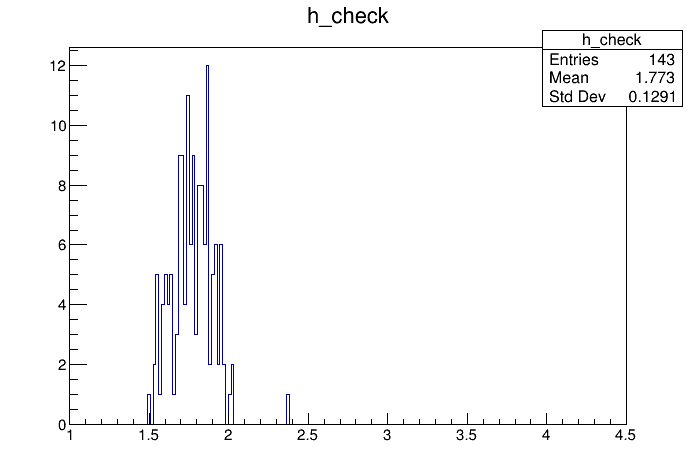

In [16]:
can = rt.TCanvas()
temp.Draw()
can.Draw()

In [34]:
chan = 'PT'
hists = []
low = 0.6
high = 1.4
step = 0.2

for j1, i1 in enumerate(np.arange(low,high,step)):
    a = i1
    for j2, i2 in enumerate(np.arange(low,high,step)):
        b = i2
        for j3, i3 in enumerate(np.arange(low,high,step)):
            c = i3
            for j4, i4 in enumerate(np.arange(low,high,step)):
                d = i4
                for j5, i5 in enumerate(np.arange(low,high,step)):
                    e = i5
                    for j6, i6 in enumerate(np.arange(low,high,step)):
                        f = i6
                        hname = 'h_a%02d_b%02d_c%02d_d%02d_e%02d_f%02d'%(j1, j2, j3, j4, j5, j6)
                        temp = rt.TH1F(hname, hname, 200, 1.0, 4.5)
                        for idx, key in enumerate(series):
                            mask = (TriggerType[idx] == 1) & (TrigDet[idx] == detNum) & (OFamps[key][chan] > 3e-6) & (OFamps[key][chan] < 4.2e-6) & (OFchiq[key][chan] < 5e5) & (abs(OFdelay[key][chan])*1e3 < 20)
                            side = 'S2'
                            A_def = OFamps[key]['PA%s'%(side)][mask]
                            B_def = OFamps[key]['PB%s'%(side)][mask]
                            C_def = OFamps[key]['PC%s'%(side)][mask]
                            D_def = OFamps[key]['PD%s'%(side)][mask]
                            E_def = OFamps[key]['PE%s'%(side)][mask]
                            F_def = OFamps[key]['PF%s'%(side)][mask]                            
                            s = a*A_def + b*B_def + c*C_def + d*D_def + e*E_def + f*F_def
                            
                            for i in s:
                                temp.Fill(i*1e6)
                        hists.append(temp)
                        #sys.exit(0)
    print('%d done'%(j1))
print('all done')

0 done
1 done
2 done
3 done
all done


Warning in <TROOT::Append>: Replacing existing TH1: h_a03_b03_c03_d03_e03_f03 (Potential memory leak).


In [22]:
len(hists)

4096

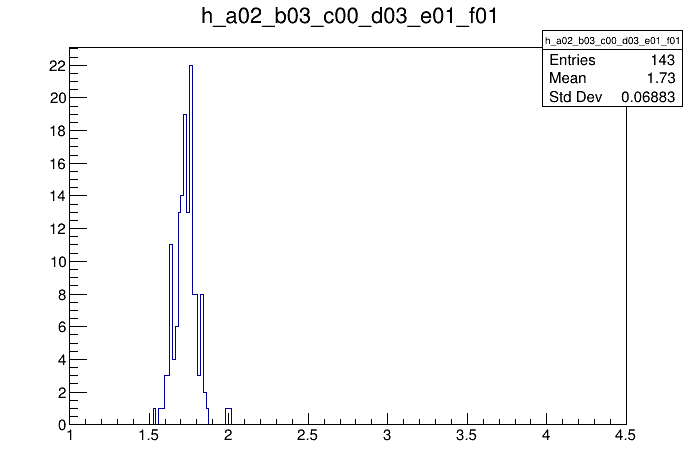

In [38]:
can = rt.TCanvas()
hists[2869].Draw()
can.Draw()

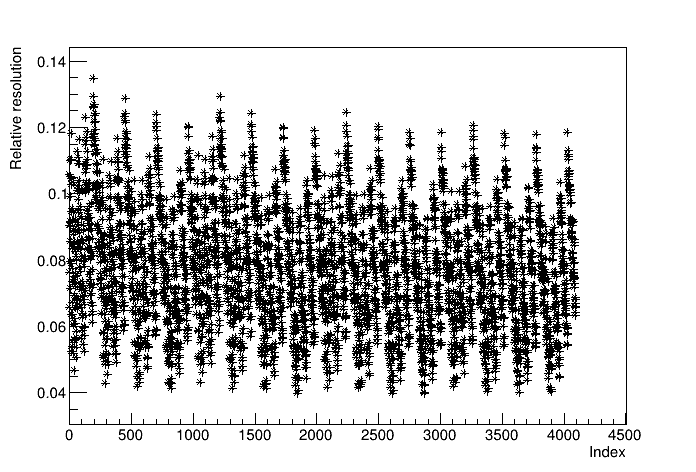

In [35]:
res = []
can = rt.TCanvas()
gr = rt.TGraph()
gr.GetXaxis().SetTitle('Index')
gr.GetYaxis().SetTitle('Relative resolution')
for i, h in enumerate(hists):
    reso_ = h.GetRMS()/h.GetMean()
    res.append(reso_)
    gr.AddPoint(i, reso_)

gr.Draw('AP*')
can.Draw()


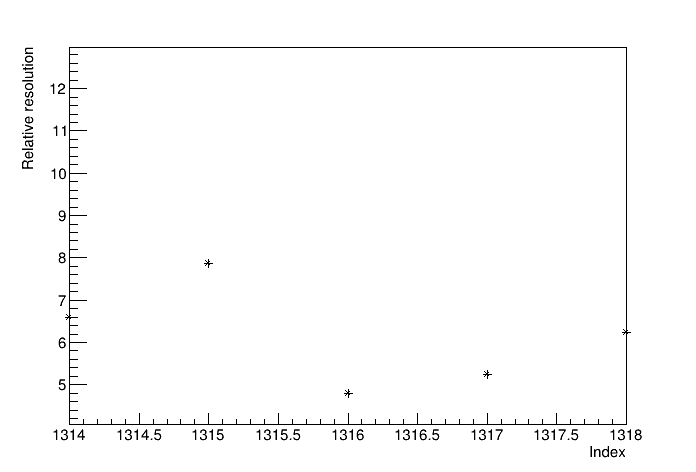

In [32]:
can = rt.TCanvas()
gr = rt.TGraph()
gr.GetXaxis().SetTitle('Index')
gr.GetYaxis().SetTitle('Relative resolution')
for i, j in enumerate(res):
    gr.AddPoint(i, j*100)

gr.Draw('AP*')
#gr.GetXaxis().SetLimits(-100,4500)
gr.GetXaxis().SetLimits(1314,1318)
can.Draw()

In [36]:
np.argmin(res)

2869

In [37]:
res[2869]

0.03978400580190866

In [27]:
len(hists)

46656

In [40]:
hists[2869].GetName()

'h_a02_b03_c00_d03_e01_f01'

In [ ]:
# calib['PAS2'] = 1.0
# calib['PBS2'] = 1.2
# calib['PCS2'] = 0.6
# calib['PDS2'] = 1.2
# calib['PES2'] = 0.8
# calib['PFS2'] = 0.8

calib['PAS1'] = 0.8
calib['PBS1'] = 0.8
calib['PCS1'] = 0.6
calib['PDS1'] = 1.0
calib['PES1'] = 0.8
calib['PFS1'] = 0.6
calib['PAS2'] = 1.0
calib['PBS2'] = 1.2
calib['PCS2'] = 0.6
calib['PDS2'] = 1.2
calib['PES2'] = 0.8
calib['PFS2'] = 0.8
reweight = 1.0

In [24]:
hists[0].GetName()

'h_a00_b00_c00_d00_e00_f00'

In [31]:
low = 0.6
high = 1.4
step = 0.2

for j1, i1 in enumerate(np.arange(low,high,step)):
    print(j1,' : ',i1)


0  :  0.6
1  :  0.8
2  :  1.0
3  :  1.2000000000000002


In [39]:
filename = 'check_calib_S2.root'
outfile = rt.TFile.Open(filename,'recreate')
outfile.cd()
for h in hists:
    h.Write()
    
outfile.Write()
outfile.Close()

In [ ]:
# hname = 'h_a%02d_b%02d_c%02d_d%02d_e%02d_f%02d'%(j1, j2, j3, j4, j5, j6)
a = 0.5
b = 1.0
c = 1.0
d = 1.0
e = 1.0
f = 1.0
calib['PAS1'] = 0.8
calib['PBS1'] = 0.8
calib['PCS1'] = 0.6
calib['PDS1'] = 1.0
calib['PES1'] = 0.8
calib['PFS1'] = 0.6
hname = 'h_check'
chan = 'PT'
temp = rt.TH1F(hname, hname, 200, 1.0, 4.5)
for idx, key in enumerate(series):
    mask = (TriggerType[idx] == 1) & (TrigDet[idx] == detNum) & (OFamps[key][chan] > 3e-6) & (OFamps[key][chan] < 4.2e-6) & (OFchiq[key][chan] < 5e5) & (abs(OFdelay[key][chan])*1e3 < 20)
    side = 'S2'
    A_def = OFamps[key]['PA%s'%(side)][mask]
    B_def = OFamps[key]['PB%s'%(side)][mask]
    C_def = OFamps[key]['PC%s'%(side)][mask]
    D_def = OFamps[key]['PD%s'%(side)][mask]
    E_def = OFamps[key]['PE%s'%(side)][mask]
    F_def = OFamps[key]['PF%s'%(side)][mask]                            
    s = a*A_def + b*B_def + c*C_def + d*D_def + e*E_def + f*F_def
    
    for i in s:
        temp.Fill(i*1e6)